In [1]:
using DrWatson
@quickactivate "MEngProject"
using MEngProject, CUDA, DifferentialEquations, PyPlot, NNlib,  ImageFiltering, Images, MEngProject, MEngProject.LamKernels, MEngProject.Laminart, MEngProject.Utils, BenchmarkTools, Test

In [2]:
using OrdinaryDiffEq, ParameterizedFunctions, LSODA, Sundials, DiffEqDevTools

In [3]:
function reshape2d_4d(img::AbstractArray)
    reshape(img, size(img)[1], size(img)[2], 1, 1)
end

reshape2d_4d (generic function with 1 method)

In [261]:
img = convert(Array{Float32,2}, load(datadir("Iine_100_100_gs.png")));
img = reshape2d_4d(img)
img = cu(img)
r = similar(img)

p = LaminartGPU.kernels(img, Parameters.parameters);

LaminartGPU.I_u!(r, img, p)
temp_out = (I = img, r = r)
p = merge(p, temp_out);

CuError: CUDA error: unspecified launch failure (code 719, ERROR_LAUNCH_FAILED)

In [103]:
tspan = (0.0f0, 5f0)
u0 = cu(reshape(zeros(Float32, p.dim_i, p.dim_j*(5*p.K+2)), p.dim_i, p.dim_j, 5*p.K+2,1));

In [14]:
arr1 = u0[:, :, 1:p.K,:]
arr2 = u0[:, :, 1:1,:];

In [15]:
f = LaminartGPU.LamFunction(
    similar(arr1), #x
    similar(arr1), #m
    similar(arr1), #s
 similar(arr2), #x_lgn,
similar(arr1), #C,
similar(arr1), #H_z,
similar(arr1), # dy_temp,
similar(arr1), # dm_temp,
similar(arr1), # dz_temp,
similar(arr1), # ds_temp,
similar(arr2), # dv_temp,
similar(arr1), # H_z_temp,
similar(arr2), #  V_temp_1,
similar(arr2), #  V_temp_2,
similar(arr1), #  A_temp,
similar(arr1), #   B_temp
    );

In [16]:
prob = ODEProblem(f, u0, tspan, p);

In [9]:
@benchmark sol = solve(prob)

BenchmarkTools.Trial: 
  memory estimate:  28.76 MiB
  allocs estimate:  560894
  --------------
  minimum time:     315.634 ms (0.00% GC)
  median time:      321.098 ms (0.00% GC)
  mean time:        336.049 ms (2.70% GC)
  maximum time:     398.161 ms (11.25% GC)
  --------------
  samples:          16
  evals/sample:     1

In [22]:
@time sol = solve(prob)

  0.416763 seconds (562.10 k allocations: 28.857 MiB)


retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 20-element Array{Float32,1}:
 0.0
 1.0f-6
 9.345251f-6
 6.192009f-5
 0.00033172502
 0.0014759909
 0.005392259
 0.017146833
 0.051452193
 0.13315387
 0.28310412
 0.49007082
 0.7197511
 1.0883753
 1.4995799
 2.081981
 2.7438252
 3.448669
 4.4254713
 5.0
u: 20-element Array{CuArray{Float32,4,Nothing},1}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 

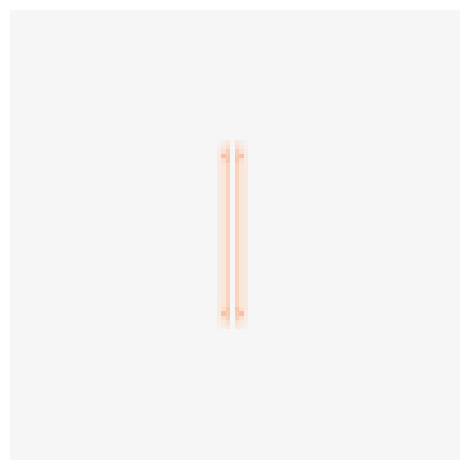

┌ Warning: Performing scalar operations on GPU arrays: This is very slow, consider disallowing these operations with `allowscalar(false)`
└ @ GPUArrays /mnt/storage_1/users/cullinanen/.julia/packages/GPUArrays/4W5rW/src/host/indexing.jl:43


In [11]:
Utils.plot_rb(sol[end][:,:,1,1])

In [12]:
findmax((sol[end][:,:,1,1]))

(0.29029807f0, CartesianIndex(68, 48))

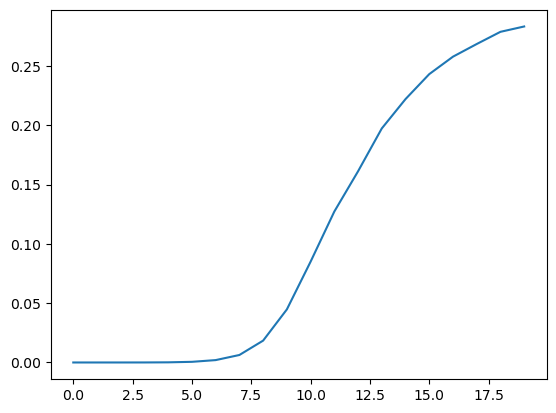

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fd701e47390>

In [13]:
plot(sol[68,48,11,1,1:end])


In [23]:
test_sol = TestSolution(sol)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: nothing
u: nothing

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: nothing
u: nothing

ArgumentError: ArgumentError: Package MATLABDiffEq not found in current path:
- Run `import Pkg; Pkg.add("MATLABDiffEq")` to install the MATLABDiffEq package.


In [41]:
test_sol = TestSolution(sol)

setups = [Dict(:alg=>DP5())
#           Dict(:alg=>dopri5())
          Dict(:alg=>Tsit5())
          Dict(:alg=>Vern7())
#           Dict(:alg=>MATLABDiffEq.ode45())
#           Dict(:alg=>MATLABDiffEq.ode113())
#           Dict(:alg=>SciPyDiffEq.RK45())
#           Dict(:alg=>SciPyDiffEq.LSODA())
#           Dict(:alg=>SciPyDiffEq.odeint())
#           Dict(:alg=>deSolveDiffEq.lsoda())
#           Dict(:alg=>deSolveDiffEq.ode45())
#           Dict(:alg=>CVODE_Adams())
  ]

names = [
  "Julia: DP5"
#   "Hairer: dopri5"
  "Julia: Tsit5"
  "Julia: Vern7"
#   "MATLAB: ode45"
#   "MATLAB: ode113"
#   "SciPy: RK45"
#   "SciPy: LSODA"
#   "SciPy: odeint"
#   "deSolve: lsoda"
#   "deSolve: ode45"
#   "Sundials: Adams"
  ]

abstols = 1.0 ./ 10.0 .^ (6:13)
reltols = 1.0 ./ 10.0 .^ (3:10)
wp = WorkPrecisionSet(prob,abstols,reltols,setups;
                      names = names,
                      appxsol=test_sol,dense=false,
                      save_everystep=false,numruns=100,maxiters=10000000,
                      timeseries_errors=false,verbose=false)
plot(wp,title="Non-stiff 1")

InterruptException: InterruptException:

In [43]:
@time sol_ = solve(prob, alg=DP5())

  0.253779 seconds (387.21 k allocations: 19.768 MiB)


retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 14-element Array{Float32,1}:
 0.0
 1.0f-6
 1.1f-5
 0.000111
 0.001111
 0.011110999
 0.097684905
 0.35977
 0.74650246
 1.3014281
 2.0785527
 3.1318936
 4.515749
 5.0
u: 14-element Array{CuArray{Float32,4,Nothing},1}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0

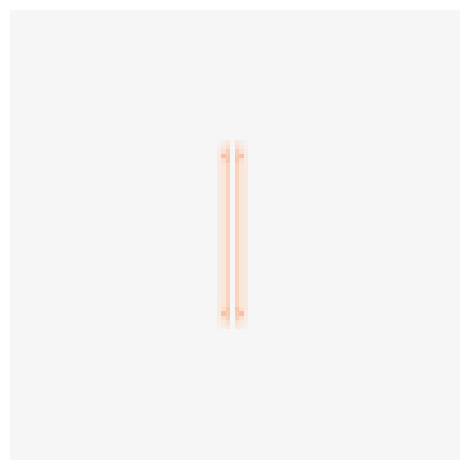

In [44]:
Utils.plot_rb(sol_[end][:,:,1,1])

In [45]:
@test sol_[end] ≈ sol[end]

Test Passed

In [58]:
@time sol_ = solve(prob, alg=ImplicitEuler())

InterruptException: InterruptException:

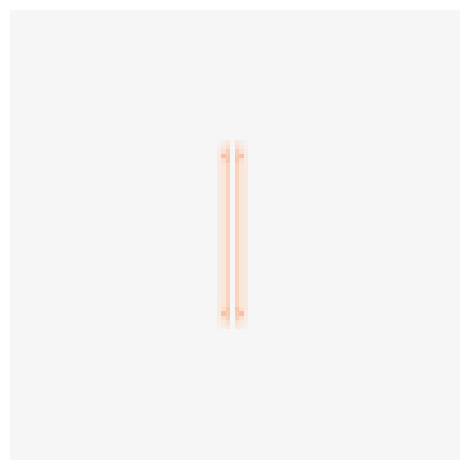

In [59]:
Utils.plot_rb(sol_[end][:,:,1,1])

In [60]:
@test sol_[end] ≈ sol[end]

Test Passed

In [61]:
@time sol_ = solve(prob, alg=ImplicitEulerExtrapolation())

┌ Warning: Threading in `ImplicitEulerExtrapolation` is currently disabled. Thus `threading` has been changed from `true` to `false`.
└ @ OrdinaryDiffEq /mnt/storage_1/users/cullinanen/.julia/packages/OrdinaryDiffEq/NsugH/src/algorithms.jl:64


OutOfGPUMemoryError: Out of GPU memory trying to allocate 53.644 GiB
Effective GPU memory usage: 4.85% (554.500 MiB/11.172 GiB)
CUDA allocator usage: 279.212 MiB
BinnedPool usage: 279.212 MiB (279.212 MiB allocated, 0 bytes cached)


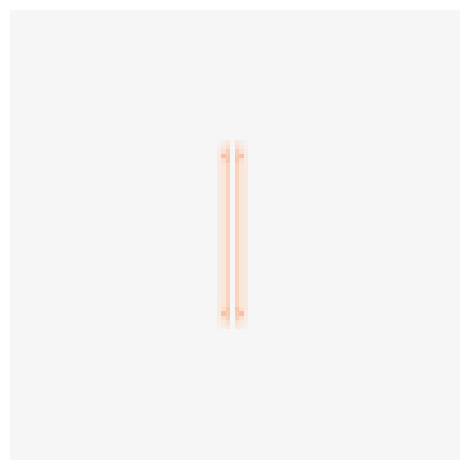

In [62]:
Utils.plot_rb(sol_[end][:,:,1,1])

In [63]:
@test sol_[end] ≈ sol[end]

Test Passed

In [64]:
@time sol_ = solve(prob, alg=Exprb43())

InterruptException: InterruptException:

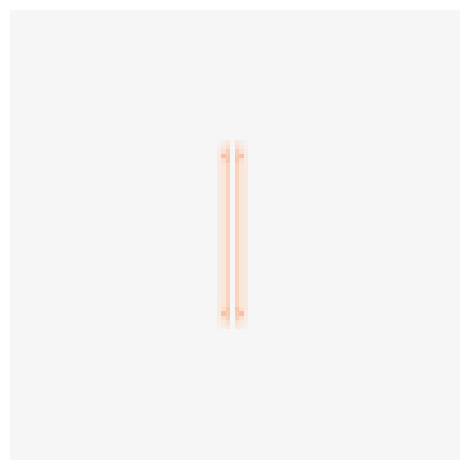

In [65]:
Utils.plot_rb(sol_[end][:,:,1,1])

In [66]:
@test sol_[end] ≈ sol[end]

Test Passed

In [71]:
@time sol_ = solve(prob, alg=lsoda())

  0.378504 seconds (558.28 k allocations: 28.599 MiB)


retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 20-element Array{Float32,1}:
 0.0
 1.0f-6
 9.345251f-6
 6.192009f-5
 0.00033172502
 0.0014759909
 0.005392259
 0.017146833
 0.051452193
 0.13315387
 0.28310412
 0.49007082
 0.7197511
 1.0883753
 1.4995799
 2.081981
 2.7438252
 3.448669
 4.4254713
 5.0
u: 20-element Array{CuArray{Float32,4,Nothing},1}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 

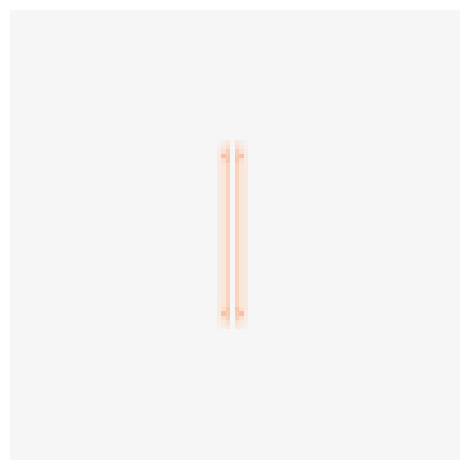

In [68]:
Utils.plot_rb(sol_[end][:,:,1,1])

In [69]:
@test sol_[end] ≈ sol[end]

Test Passed

In [9]:
tspan_ = (0.0f0, 1000f0)

(0.0f0, 1000.0f0)

In [10]:
prob_ = ODEProblem(f, u0, tspan_, p);

In [11]:
@time sol_ = solve(prob_)

109.939369 seconds (149.33 M allocations: 7.287 GiB, 3.66% gc time)


retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 1055-element Array{Float32,1}:
    0.0
    1.0f-6
    9.345251f-6
    6.192009f-5
    0.00033172502
    0.0014759909
    0.005392259
    0.017146833
    0.051452193
    0.13315387
    0.28310412
    0.49007082
    0.7197511
    ⋮
  989.7602
  990.7217
  991.6828
  992.64325
  993.60315
  994.56287
  995.5229
  996.4835
  997.4447
  998.4062
  999.3675
 1000.0
u: 1055-element Array{CuArray{Float32,4,Nothing},1}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 

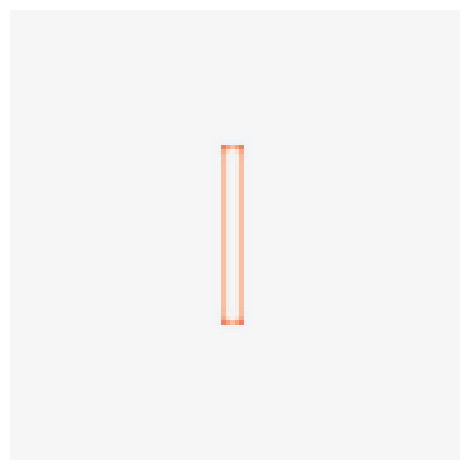

┌ Warning: Performing scalar operations on GPU arrays: This is very slow, consider disallowing these operations with `allowscalar(false)`
└ @ GPUArrays /mnt/storage_1/users/cullinanen/.julia/packages/GPUArrays/4W5rW/src/host/indexing.jl:43


In [12]:
Utils.plot_rb(sol_[end][:,:,11,1])

In [13]:
@test sol_[end] ≈ sol[end]

Error During Test at In[13]:1
  Test threw exception
  Expression: sol_[end] ≈ sol[end]
  UndefVarError: sol not defined
  Stacktrace:
   [1] top-level scope at In[13]:1
   [2] eval at ./boot.jl:331 [inlined]
   [3] softscope_include_string(::Module, ::String, ::String) at /mnt/storage_1/users/cullinanen/.julia/packages/SoftGlobalScope/cSbw5/src/SoftGlobalScope.jl:218
   [4] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /mnt/storage_1/users/cullinanen/.julia/packages/IJulia/DrVMH/src/execute_request.jl:67
   [5] #invokelatest#1 at ./essentials.jl:712 [inlined]
   [6] invokelatest at ./essentials.jl:711 [inlined]
   [7] eventloop(::ZMQ.Socket) at /mnt/storage_1/users/cullinanen/.julia/packages/IJulia/DrVMH/src/eventloop.jl:8
   [8] (::IJulia.var"#15#18")() at ./task.jl:358
  


Test.FallbackTestSetException: There was an error during testing

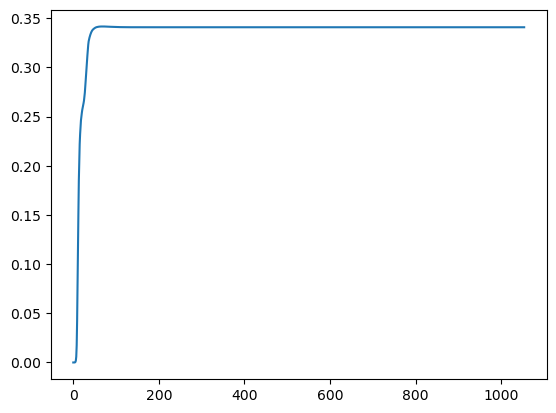

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f6838096250>

In [14]:
k=12
m = findmax((sol_[end][:,:,k,1]))[2]

plot(sol_[m[1],m[2],k,1,1:end])

In [15]:
@test sol_[900] ≈ sol_[end]

Test Failed at In[15]:1
  Expression: sol_[900] ≈ sol_[end]
   Evaluated: Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0] ≈ Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0

Test.FallbackTestSetException: There was an error during testing

In [28]:
abstols = 1 ./10 .^ (3:10)
reltols = 1 ./10 .^ (3:10)
setups = [Dict(:alg=>DP5())
          #Dict(:alg=>ode45()) # fail
#           Dict(:alg=>dopri5())
          Dict(:alg=>Tsit5())
          Dict(:alg=>Vern6())
]
wp = WorkPrecisionSet(prob,abstols,reltols,setups;appxsol=test_sol,save_everystep=false,maxiters=2,numruns=1)
plot(wp)

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /mnt/storage_1/users/cullinanen/.julia/packages/DiffEqBase/ytJuW/src/integrator_interface.jl:329


InterruptException: InterruptException:

In [ ]:
sol

In [30]:
@time sol_ = solve(prob, alg=Tsit5())

  0.423475 seconds (562.06 k allocations: 28.797 MiB)


retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 20-element Array{Float32,1}:
 0.0
 1.0f-6
 9.345251f-6
 6.192009f-5
 0.00033172502
 0.0014759909
 0.005392259
 0.017146833
 0.051452193
 0.13315387
 0.28310412
 0.49007082
 0.7197511
 1.0883753
 1.4995799
 2.081981
 2.7438252
 3.448669
 4.4254713
 5.0
u: 20-element Array{CuArray{Float32,4,Nothing},1}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 

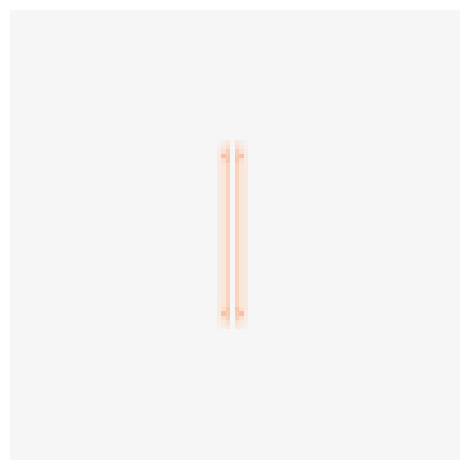

In [31]:
Utils.plot_rb(sol_[end][:,:,1,1])

In [32]:
@test sol_[end] ≈ sol[end]

Test Passed

In [38]:
@time sol_  =solve(prob, alg=Vern6())

  1.280786 seconds (1.78 M allocations: 91.362 MiB)


retcode: Success
Interpolation: specialized 6th order lazy interpolation
t: 47-element Array{Float32,1}:
 0.0
 1.0f-6
 4.8260254f-6
 1.6664126f-5
 5.009814f-5
 0.00012864155
 0.0002759929
 0.0005511006
 0.000990004
 0.0016668192
 0.0027296916
 0.00439269
 0.006878926
 ⋮
 1.2842804
 1.4828758
 1.7098194
 1.9664803
 2.2408519
 2.5568519
 2.9165232
 3.336051
 3.7895575
 4.3475614
 4.9437294
 5.0
u: 47-element Array{CuArray{Float32,4,Nothing},1}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.

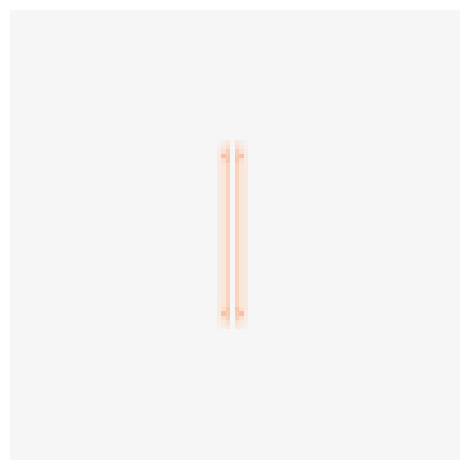

In [39]:
Utils.plot_rb(sol_[end][:,:,1,1])

In [40]:
@test sol_[end] ≈ sol[end]

Test Passed

In [75]:
@time sol_ = solve(prob, alg=TRBDF2())

InterruptException: InterruptException:

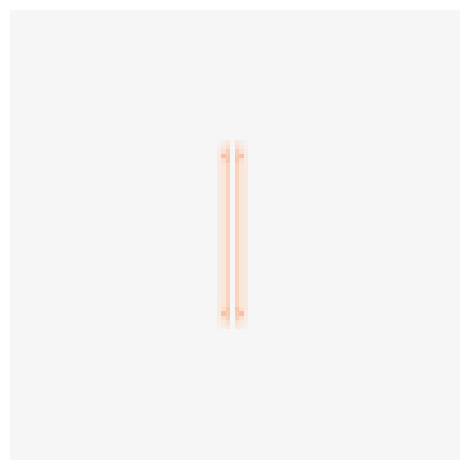

In [42]:
Utils.plot_rb(sol_[end][:,:,1,1])

In [43]:
@test sol_[end] ≈ sol[end]

Test Passed

In [76]:
@code_llvm f(duu, u0, p, 0.0f0)


;  @ /mnt/storage_1/users/cullinanen/.julia/dev/MEngProject.jl/src/LaminartGPU.jl:46 within `LamFunction'
define void @julia_LamFunction_25442(%jl_value_t addrspace(10)* nonnull align 8 dereferenceable(128), %jl_value_t addrspace(10)* nonnull align 8 dereferenceable(72), %jl_value_t addrspace(10)* nonnull align 8 dereferenceable(72), %jl_value_t addrspace(10)* nonnull align 8 dereferenceable(352), float) {
top:
  %5 = alloca %jl_value_t addrspace(10)*, i32 8
  %gcframe = alloca %jl_value_t addrspace(10)*, i32 18, align 16
  %6 = bitcast %jl_value_t addrspace(10)** %gcframe to i8*
  call void @llvm.memset.p0i8.i32(i8* align 16 %6, i8 0, i32 144, i1 false)
  %7 = alloca <4 x i64>, align 8
  %tmpcast = bitcast <4 x i64>* %7 to [4 x [1 x i64]]*
  %8 = alloca <4 x i64>, align 8
  %tmpcast252 = bitcast <4 x i64>* %8 to [4 x i64]*
  %9 = alloca [4 x [1 x i64]], align 8
  %thread_ptr = call i8* asm "movq %fs:0, $0", "=r"()
  %ptls_i8 = getelementptr i8, i8* %thread_ptr, i64 -15712
  %ptls = b

In [101]:
CUDA.allowscalar(false)

In [86]:
@time f(duu, u0, p, 0.0f0)

  0.004724 seconds (4.62 k allocations: 240.703 KiB)


In [87]:
CUDA.allowscalar(true)

In [90]:
@time f(duu, u0, p, 0.0f0)

  0.004325 seconds (4.62 k allocations: 240.859 KiB)


In [95]:
duu = u0
@time f(duu, u0, p, 0.0f0)

  0.004397 seconds (4.62 k allocations: 240.859 KiB)


In [102]:
@time sol = solve(prob)

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq /mnt/storage_1/users/cullinanen/.julia/packages/OrdinaryDiffEq/NsugH/src/initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq /mnt/storage_1/users/cullinanen/.julia/packages/OrdinaryDiffEq/NsugH/src/solve.jl:456


  0.024133 seconds (16.43 k allocations: 845.547 KiB)


┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase /mnt/storage_1/users/cullinanen/.julia/packages/DiffEqBase/ytJuW/src/integrator_interface.jl:323


retcode: DtNaN
Interpolation: specialized 4th order "free" interpolation
t: 1-element Array{Float32,1}:
 0.0
u: 1-element Array{CuArray{Float32,4,Nothing},1}:
 [NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN]

[NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN]

[NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN]

...

[NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN]

[NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN]

[NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN]

In [109]:
# duu = u0
@time f(duu, u0, p, 0.0f0)

  0.004550 seconds (4.62 k allocations: 240.859 KiB)


In [110]:
@which f(duu, u0, p, 0.0f0) 

(ff::MEngProject.LaminartGPU.LamFunction)(du, u, p, t) in MEngProject.LaminartGPU at /mnt/storage_1/users/cullinanen/.julia/dev/MEngProject.jl/src/LaminartGPU.jl:46

In [111]:
@device_code_llvm f(duu, u0, p, 0.0f0)  

; PTX CompilerJob of kernel broadcast(CUDA.CuKernelContext, CuDeviceArray{Float32,4,CUDA.AS.Global}, Base.Broadcast.Broadcasted{Nothing,NTuple{4,Base.OneTo{Int64}},typeof(identity),Tuple{Base.Broadcast.Extruded{SubArray{Float32,4,CuDeviceArray{Float32,4,CUDA.AS.Global},Tuple{Base.Slice{Base.OneTo{Int64}},Base.Slice{Base.OneTo{Int64}},UnitRange{Int64},Base.Slice{Base.OneTo{Int64}}},false},NTuple{4,Bool},NTuple{4,Int64}}}}) for sm_35

;  @ /mnt/storage_1/users/cullinanen/.julia/packages/GPUArrays/4W5rW/src/host/broadcast.jl:58 within `#20'
define ptx_kernel void @_Z15julia_broadcast15CuKernelContext13CuDeviceArrayI7Float32Li4E6GlobalE11BroadcastedIv5TupleI5OneToI5Int64ES5_IS6_ES5_IS6_ES5_IS6_EE9_identityS4_I8ExtrudedI8SubArrayIS1_Li4ES0_IS1_Li4ES2_ES4_I5SliceIS5_IS6_EES10_IS5_IS6_EE9UnitRangeIS6_ES10_IS5_IS6_EEELifalseEES4_I4BoolS12_S12_S12_ES4_IS6_S6_S6_S6_EEEE({ [4 x i64], i64 } addrspace(11)* byval nocapture nonnull readonly dereferenceable(40), { [1 x { { { [4 x i64], i64 }, { [1 x [

Excessive output truncated after 605160 bytes.

In [ ]:
nvprof --profile-from-start off julia
julia> const x = CuArray{Float32}(undef, 1024)
julia> identity.(x)
julia> CUDAdrv.@profile begin
         identity.(x)
       end
julia> exit()


In [113]:
@code_warntype  solve(prob)

Variables
  #self#::Core.Compiler.Const(DiffEqBase.solve, false)
  prob::ODEProblem{CuArray{Float32,4,Nothing},Tuple{Float32,Float32},true,NamedTuple{(:K, :δ_v, :δ_c, :δ_m, :δ_z, :δ_s, :σ_1, :C_1, :C_2, :σ_2, :γ, :α, :ϕ, :Γ, :v_21, :μ, :ν, :n, :att, :η_p, :η_m, :λ, :a_23_ex, :a_23_in, :v12_6, :v12_4, :ψ, :C_AB_l, :H_σ_x, :H_σ_y, :H_fact, :H_l, :T_fact, :T_p_m, :T_v2_fact, :H_size, :W_size, :lgn_equ_u, :lgn_equ_A, :lgn_equ_B, :filling, :W_l, :k_gauss_1, :k_gauss_2, :k_C_A, :k_C_B, :k_x_lgn, :k_W_p, :k_W_m, :k_H, :k_T_p, :k_T_m, :k_T_p_v2, :k_T_m_v2, :dim_i, :dim_j, :x_V2, :ν_pw_n, :I, :r),Tuple{Int64,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Int64,Float32,Float32,Float32,Int64,Array{Float32,1},Float32,Float32,Int64,Int64,Float32,Float32,Float32,String,Int64,CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float

In [116]:
@code_warntype f(duu, u0, p, 0.0f0)

Variables
  ff::MEngProject.LaminartGPU.LamFunction{CuArray{Float32,4,Nothing}}
  du::CuArray{Float32,4,Nothing}
  u::CuArray{Float32,4,Nothing}
  p::NamedTuple{(:K, :δ_v, :δ_c, :δ_m, :δ_z, :δ_s, :σ_1, :C_1, :C_2, :σ_2, :γ, :α, :ϕ, :Γ, :v_21, :μ, :ν, :n, :att, :η_p, :η_m, :λ, :a_23_ex, :a_23_in, :v12_6, :v12_4, :ψ, :C_AB_l, :H_σ_x, :H_σ_y, :H_fact, :H_l, :T_fact, :T_p_m, :T_v2_fact, :H_size, :W_size, :lgn_equ_u, :lgn_equ_A, :lgn_equ_B, :filling, :W_l, :k_gauss_1, :k_gauss_2, :k_C_A, :k_C_B, :k_x_lgn, :k_W_p, :k_W_m, :k_H, :k_T_p, :k_T_m, :k_T_p_v2, :k_T_m_v2, :dim_i, :dim_j, :x_V2, :ν_pw_n, :I, :r),Tuple{Int64,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Int64,Float32,Float32,Float32,Int64,Array{Float32,1},Float32,Float32,Int64,Int64,Float32,Float32,Float32,String,Int64,CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},Cu

In [124]:
@code_warntype @view u0[:, :, 1:p.K,:]

Variables
  #self#::Core.Compiler.Const(@view, false)
  __source__::LineNumberNode
  __module__::Module
  ex@_4::Expr
  msg::Expr
  ex@_6::Any
  @_7::Bool
  @_8::Any

Body::Expr
1 ──       nothing
│          (ex@_6 = ex@_4)
│          Core.NewvarNode(:(msg))
│    %4  = Base.getproperty(Base.Meta, :isexpr)::Core.Compiler.Const(Base.Meta.isexpr, false)
│    %5  = ex@_6::Expr::Expr
│    %6  = (%4)(%5, :ref)::Bool
└───       goto #15 if not %6
2 ──       (ex@_6 = Base.replace_ref_end!(ex@_6::Expr))
│    %9  = Base.getproperty(Base.Meta, :isexpr)::Core.Compiler.Const(Base.Meta.isexpr, false)
│    %10 = ex@_6::Expr::Expr
│    %11 = (%9)(%10, :ref)::Bool
└───       goto #4 if not %11
3 ── %13 = Core.tuple(:call, Base.view)::Core.Compiler.Const((:call, view), false)
│    %14 = Base.getproperty(ex@_6::Expr, :args)::Array{Any,1}
│          (ex@_6 = Core._apply_iterate(Base.iterate, Base.Expr, %13, %14))
└───       goto #14
4 ── %17 = Base.getproperty(Base.Meta, :isexpr)::Core.Compiler.Const(Base

LoadError: UndefVarError: @profile not defined

In [128]:
using Traceur
@trace @. f.x =  @view u0[:, :, 1:p.K,:] 

┌ Warning: getindex returns Union{Colon, UnitRange{Int64}}
└ @ tuple.jl:24
┌ Warning: getindex returns Union{Base.Slice{Base.OneTo{Int64}}, UnitRange{Int64}}
└ @ tuple.jl:24
┌ Warning: getindex returns Union{Base.Slice{Base.OneTo{Int64}}, UnitRange{Int64}}
└ @ tuple.jl:24
┌ Warning: getindex returns Union{Base.Slice{Base.OneTo{Int64}}, UnitRange{Int64}}
└ @ tuple.jl:24
┌ Warning: dynamic dispatch to CUDA._cuview(A, I, CUDA.NonContiguous())
└ @ ~/.julia/packages/CUDA/h38pe/src/subarray.jl:24


ErrorException: type Symbol has no field wrapper

In [129]:
using Sherlogs
A = Sherlog64.(rand(1000,1000));
b = Sherlog64.(rand(1000));
x = A\b;
lb = get_logbook()

LogBook(UInt64[0x000000000000048e, 0x0000000000000143, 0x0000000000000142, 0x000000000000013e, 0x0000000000000149, 0x0000000000000128, 0x000000000000013c, 0x0000000000000105, 0x00000000000000fd, 0x00000000000000f6  …  0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000])

In [130]:
pp = Sherlog32.(p) 

ArgumentError: ArgumentError: broadcasting over dictionaries and `NamedTuple`s is reserved

In [131]:
img = convert(Array{Float32,2}, load(datadir("Iine_100_100_gs.png")));
img = reshape2d_4d(img)
img = Sherlog32.(img)

100×100×1×1 Array{Sherlog32{Float16,1},4}:
[:, :, 1, 1] =
 Sherlog32(0.0)  Sherlog32(0.0)  …  Sherlog32(0.0)  Sherlog32(0.0)
 Sherlog32(0.0)  Sherlog32(0.0)     Sherlog32(0.0)  Sherlog32(0.0)
 Sherlog32(0.0)  Sherlog32(0.0)     Sherlog32(0.0)  Sherlog32(0.0)
 Sherlog32(0.0)  Sherlog32(0.0)     Sherlog32(0.0)  Sherlog32(0.0)
 Sherlog32(0.0)  Sherlog32(0.0)     Sherlog32(0.0)  Sherlog32(0.0)
 Sherlog32(0.0)  Sherlog32(0.0)  …  Sherlog32(0.0)  Sherlog32(0.0)
 Sherlog32(0.0)  Sherlog32(0.0)     Sherlog32(0.0)  Sherlog32(0.0)
 Sherlog32(0.0)  Sherlog32(0.0)     Sherlog32(0.0)  Sherlog32(0.0)
 Sherlog32(0.0)  Sherlog32(0.0)     Sherlog32(0.0)  Sherlog32(0.0)
 Sherlog32(0.0)  Sherlog32(0.0)     Sherlog32(0.0)  Sherlog32(0.0)
 Sherlog32(0.0)  Sherlog32(0.0)  …  Sherlog32(0.0)  Sherlog32(0.0)
 Sherlog32(0.0)  Sherlog32(0.0)     Sherlog32(0.0)  Sherlog32(0.0)
 Sherlog32(0.0)  Sherlog32(0.0)     Sherlog32(0.0)  Sherlog32(0.0)
  ⋮                              ⋱                  
 Sherlog32(0.0)  S

In [133]:
p_temp = (σ_1 = Sherlog32(1.0f0),
σ_2 = Sherlog32(0.5f0),
H_σ_x = Sherlog32(3.0f0),
H_σ_y = Sherlog32(4.0f0))

(σ_1 = Sherlog32(1.0), σ_2 = Sherlog32(0.5), H_σ_x = Sherlog32(3.0), H_σ_y = Sherlog32(4.0))

In [144]:
parameters = (K = 2,
δ_v = Sherlog32(1.25f0),
δ_c = Sherlog32(0.25f0),
δ_m = Sherlog32(0.01875f0),
δ_z = Sherlog32(0.125f0),
δ_s = Sherlog32(2.5f0),
σ_1 = p_temp.σ_1,
C_1 = Sherlog32(1.5f0),
C_2 = Sherlog32(0.075f0),
σ_2 = p_temp.σ_2,
γ = Sherlog32(10.0f0),
α = Sherlog32(0.5f0),
ϕ = Sherlog32(2.0f0),
Γ = Sherlog32(0.2f0),
v_21 = Sherlog32(0.0f0), #1.0
μ = Sherlog32(2.0f0),
ν = Sherlog32(1.1f0),
n = Sherlog32(6.0f0),
att = Sherlog32(0.0f0),# p25
η_p = Sherlog32(2.1f0),
η_m = Sherlog32(1.5f0),
λ = Sherlog32(1.5f0),
a_23_ex = Sherlog32(3.0f0),
a_23_in = Sherlog32(0.5f0),
v12_6 = Sherlog32(1.0f0),
v12_4 = Sherlog32(5.0f0),
ψ = Sherlog32(0.5f0),
C_AB_l =  4*ceil(Int, float32(p_temp.σ_2))+1,
H_σ_x = p_temp.H_σ_x,
H_σ_y = p_temp.H_σ_y,
H_fact = Sherlog32(5.0f0),
# H_l =  4*ceil(Int, max(p_temp.H_σ_x, p_temp.H_σ_y))+1,
H_l = 19,
T_fact = [Sherlog32(0.87f0),Sherlog32(0.13f0)],       #avg TP same orient, other orient
T_p_m = Sherlog32(0.302f0),    #avg TM/TP
T_v2_fact = Sherlog32(0.625f0),     #T in V2 = T*
# W, H sizes
H_size = 19,
W_size = 19,
# customn parameters for controling feedback, lgn equlibrum
lgn_equ_u = Sherlog32(1.0f0),
lgn_equ_A = Sherlog32(0.0f0),
lgn_equ_B = Sherlog32(0.0f0),
filling = "circular",
W_l = 19)

(K = 2, δ_v = Sherlog32(1.25), δ_c = Sherlog32(0.25), δ_m = Sherlog32(0.01875), δ_z = Sherlog32(0.125), δ_s = Sherlog32(2.5), σ_1 = Sherlog32(1.0), C_1 = Sherlog32(1.5), C_2 = Sherlog32(0.075), σ_2 = Sherlog32(0.5), γ = Sherlog32(10.0), α = Sherlog32(0.5), ϕ = Sherlog32(2.0), Γ = Sherlog32(0.2), v_21 = Sherlog32(0.0), μ = Sherlog32(2.0), ν = Sherlog32(1.1), n = Sherlog32(6.0), att = Sherlog32(0.0), η_p = Sherlog32(2.1), η_m = Sherlog32(1.5), λ = Sherlog32(1.5), a_23_ex = Sherlog32(3.0), a_23_in = Sherlog32(0.5), v12_6 = Sherlog32(1.0), v12_4 = Sherlog32(5.0), ψ = Sherlog32(0.5), C_AB_l = 5, H_σ_x = Sherlog32(3.0), H_σ_y = Sherlog32(4.0), H_fact = Sherlog32(5.0), H_l = 19, T_fact = Sherlog32{Float16,1}[Sherlog32(0.87), Sherlog32(0.13)], T_p_m = Sherlog32(0.302), T_v2_fact = Sherlog32(0.625), H_size = 19, W_size = 19, lgn_equ_u = Sherlog32(1.0), lgn_equ_A = Sherlog32(0.0), lgn_equ_B = Sherlog32(0.0), filling = "circular", W_l = 19)

In [145]:
function kernels_(img::AbstractArray, p::NamedTuple)
       C_A_temp = reshape(
        Array{eltype(img)}(undef, p.C_AB_l, p.C_AB_l * p.K),
        p.C_AB_l,
        p.C_AB_l,
        1,
		p.K
    )
C_B_temp = similar(C_A_temp)
	    H_temp = reshape(
        zeros(eltype(img), p.H_l, p.H_l * p.K * p.K),
        p.H_l,
        p.H_l,
        p.K,
    p.K)
 T_temp = reshape(Array{eltype(img)}(undef, p.K * p.K), 1, 1, p.K, p.K)     
 W_temp =
        reshape(Array{eltype(img)}(undef, p.W_l, p.W_l * p.K * p.K), p.W_l, p.W_l, p.K, p.K)
    for k ∈ 1:p.K
        θ = π * (k - Sherlog32(1.0f0)) / p.K
        C_A_temp[:, :, 1,k] = LamKernels.kern_d(p.σ_2, θ)          
        C_B_temp[:, :, 1,k] = LamKernels.kern_b(p.σ_2, θ)               
        H_temp[:, :, k,k] = p.H_fact .* LamKernels.gaussian_rot(p.H_σ_x, p.H_σ_y, θ, p.H_l)  
        T_temp[1, 1, k,1] = p.T_fact[k]
        T_temp[1, 1, 2,2] = p.T_fact[1]
        T_temp[1, 1, 1,2] = p.T_fact[2]

    end

    W_temp[:, :, 1, 1] =
        Sherlog32(5f0) .* LamKernels.gaussian_rot(Sherlog32(3f0), Sherlog32(0.8f0), Sherlog32(0f0), p.W_l) .+
        LamKernels.gaussian_rot(Sherlog32(0.4f0), Sherlog32(1f0), Sherlog32(0f0), p.W_l)
    
	W_temp[:, :, 2, 2] =
        Sherlog32(5f0) .* LamKernels.gaussian_rot(Sherlog32(3f0), Sherlog32(0.8f0),  Sherlog32(π / 2f0), p.W_l) .+
        LamKernels.gaussian_rot(Sherlog32(0.4f0), Sherlog32(1f0), Sherlog32(π / 2f0), p.W_l)
    
	W_temp[:, :, 1, 2] = relu.(
        Sherlog32(0.2f0) .- LamKernels.gaussian_rot(Sherlog32(2f0), Sherlog32(0.6f0), Sherlog32(0f0), p.W_l) .-
        LamKernels.gaussian_rot(Sherlog32(0.3f0), Sherlog32(1.2f0), Sherlog32(0f0), p.W_l))
    
	W_temp[:, :, 2, 1] = relu.(
        Sherlog32(0.2f0) .- LamKernels.gaussian_rot(Sherlog32(2f0), Sherlog32(0.6f0), Sherlog32(π / 2f0), p.W_l) .-
        LamKernels.gaussian_rot(Sherlog32(0.3f0), Sherlog32(1.2f0), Sherlog32(π / 2f0), p.W_l))
	
	
	temp_out = (
        k_gauss_1 = reshape2d_4d(Kernel.gaussian(p.σ_1)),
        k_gauss_2 = reshape2d_4d(Kernel.gaussian(p.σ_2)),
        k_C_A = C_A_temp,
        k_C_B = C_B_temp,
		
		k_x_lgn = reshape(ones(Float32,1,p.K),1,1,p.K,1),
        k_W_p = W_temp,
        k_W_m = W_temp,
        k_H = H_temp,
        k_T_p = T_temp,
        k_T_m = p.T_p_m .* T_temp,
        k_T_p_v2 = p.T_v2_fact .* T_temp,
        k_T_m_v2 = p.T_v2_fact .* p.T_p_m .* T_temp,
        dim_i = size(img)[1],
        dim_j = size(img)[2],
        x_V2 = reshape(zeros(Float32, size(img)[1], size(img)[2] * p.K), size(img)[1], size(img)[2],p.K,1),
ν_pw_n= p.ν^p.n, )
merge(p, temp_out)
end

kernels_ (generic function with 1 method)

In [ ]:
# img = convert(Array{Float32,2}, load(datadir("Iine_100_100_gs.png")));
# img = reshape2d_4d(img)
# img = cu(img)
# r = similar(img)

p = LaminartGPU.kernels_(img, Parameters.parameters);

LaminartGPU.I_u!(r, img, p)
temp_out = (I = img, r = r)
p = merge(p, temp_out);

In [147]:
# r = similar(img)

# p = kernels_(img, parameters);

# LaminartGPU.I_u!(r, img, p)
# temp_out = (I = img, r = r)
# p = merge(p, temp_out);

MethodError: MethodError: no method matching round(::Sherlog32{Float16,1}, ::RoundingMode{:Up})
Closest candidates are:
  round(::Real, ::RoundingMode; digits, sigdigits, base) at floatfuncs.jl:129
  round(!Matched::Float64, ::RoundingMode{:Up}) at float.jl:374
  round(!Matched::Float32, ::RoundingMode{:Up}) at float.jl:375
  ...

In [150]:
tspan = (Sherlog32(0.0f0), Sherlog32(5f0))
u0 = Sherlog32.((reshape(zeros(Float32, p.dim_i, p.dim_j*(5*p.K+2)), p.dim_i, p.dim_j, 5*p.K+2,1)));

In [151]:
arr1 = u0[:, :, 1:p.K,:]
arr2 = u0[:, :, 1:1,:];

In [154]:
f = LaminartGPU.LamFunction(
    similar(arr1), #x
    similar(arr1), #m
    similar(arr1), #s
 similar(arr2), #x_lgn,
similar(arr1), #C,
similar(arr1), #H_z,
similar(arr1), # dy_temp,
similar(arr1), # dm_temp,
similar(arr1), # dz_temp,
similar(arr1), # ds_temp,
similar(arr2), # dv_temp,
similar(arr1), # H_z_temp,
similar(arr2), #  V_temp_1,
similar(arr2), #  V_temp_2,
similar(arr1), #  A_temp,
similar(arr1), #   B_temp
    );

In [155]:
prob = ODEProblem(f, u0, tspan, p);

In [156]:
@benchmark sol = solve(prob)

MethodError: MethodError: Sherlog32{Float16,1}(::Rational{Int64}) is ambiguous. Candidates:
  (::Type{T})(x::Rational{S}) where {S, T<:AbstractFloat} in Base at rational.jl:99
  (::Type{Sherlog32{T,i}})(val) where {T<:AbstractFloat, i} in Sherlogs at /mnt/storage_1/users/cullinanen/.julia/packages/Sherlogs/oPUPU/src/Sherlog32.jl:2
Possible fix, define
  (::Type{Sherlog32{T,i}})(::Rational{S}) where {T<:AbstractFloat, i, S}

In [157]:
@time solve(prob)

MethodError: MethodError: Sherlog32{Float16,1}(::Rational{Int64}) is ambiguous. Candidates:
  (::Type{T})(x::Rational{S}) where {S, T<:AbstractFloat} in Base at rational.jl:99
  (::Type{Sherlog32{T,i}})(val) where {T<:AbstractFloat, i} in Sherlogs at /mnt/storage_1/users/cullinanen/.julia/packages/Sherlogs/oPUPU/src/Sherlog32.jl:2
Possible fix, define
  (::Type{Sherlog32{T,i}})(::Rational{S}) where {T<:AbstractFloat, i, S}

In [161]:
duu = u0
@time f(duu, u0, p, Sherlog32(0.0f0))

  0.000086 seconds (3 allocations: 240 bytes)


In [162]:
duu

100×100×12×1 Array{Sherlog32{Float16,1},4}:
[:, :, 1, 1] =
 Sherlog32(0.0)  Sherlog32(0.0)  …  Sherlog32(0.0)  Sherlog32(0.0)
 Sherlog32(0.0)  Sherlog32(0.0)     Sherlog32(0.0)  Sherlog32(0.0)
 Sherlog32(0.0)  Sherlog32(0.0)     Sherlog32(0.0)  Sherlog32(0.0)
 Sherlog32(0.0)  Sherlog32(0.0)     Sherlog32(0.0)  Sherlog32(0.0)
 Sherlog32(0.0)  Sherlog32(0.0)     Sherlog32(0.0)  Sherlog32(0.0)
 Sherlog32(0.0)  Sherlog32(0.0)  …  Sherlog32(0.0)  Sherlog32(0.0)
 Sherlog32(0.0)  Sherlog32(0.0)     Sherlog32(0.0)  Sherlog32(0.0)
 Sherlog32(0.0)  Sherlog32(0.0)     Sherlog32(0.0)  Sherlog32(0.0)
 Sherlog32(0.0)  Sherlog32(0.0)     Sherlog32(0.0)  Sherlog32(0.0)
 Sherlog32(0.0)  Sherlog32(0.0)     Sherlog32(0.0)  Sherlog32(0.0)
 Sherlog32(0.0)  Sherlog32(0.0)  …  Sherlog32(0.0)  Sherlog32(0.0)
 Sherlog32(0.0)  Sherlog32(0.0)     Sherlog32(0.0)  Sherlog32(0.0)
 Sherlog32(0.0)  Sherlog32(0.0)     Sherlog32(0.0)  Sherlog32(0.0)
  ⋮                              ⋱                  
 Sherlog32(0.0)  

In [168]:
lb = get_logbook()

LogBook(UInt64[0x000000000007dd78, 0x0000000000000143, 0x0000000000000142, 0x000000000000013e, 0x0000000000000149, 0x0000000000000128, 0x000000000000013c, 0x0000000000000105, 0x00000000000000fd, 0x00000000000000f6  …  0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000])

In [183]:
plot(lb./sum(lb))

MethodError: MethodError: no method matching length(::LogBook)
Closest candidates are:
  length(!Matched::Core.SimpleVector) at essentials.jl:596
  length(!Matched::Base.MethodList) at reflection.jl:852
  length(!Matched::Core.MethodTable) at reflection.jl:938
  ...

In [184]:
sum(lb)

670207116

In [172]:
lb[1]

MethodError: MethodError: no method matching getindex(::LogBook, ::Int64)

In [173]:
length(lb)

MethodError: MethodError: no method matching length(::LogBook)
Closest candidates are:
  length(!Matched::Core.SimpleVector) at essentials.jl:596
  length(!Matched::Base.MethodList) at reflection.jl:852
  length(!Matched::Core.MethodTable) at reflection.jl:938
  ...

In [182]:
lb = get_logbook(1)

LogBook(UInt64[0x000000000007dd78, 0x0000000000000143, 0x0000000000000142, 0x000000000000013e, 0x0000000000000149, 0x0000000000000128, 0x000000000000013c, 0x0000000000000105, 0x00000000000000fd, 0x00000000000000f6  …  0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000])

In [186]:
lb[1]

MethodError: MethodError: no method matching getindex(::LogBook, ::Int64)

In [187]:
a = [1,2,3]

3-element Array{Int64,1}:
 1
 2
 3

In [188]:
aa = cu(a)

3-element CuArray{Int64,1,Nothing}:
 1
 2
 3

In [205]:
a = CUDA.rand(100,100)

100×100 CuArray{Float32,2,Nothing}:
 0.618219   0.799418   0.860789   …  0.181544   0.604606  0.876766
 0.230928   0.262083   0.989088      0.725306   0.342132  0.57437
 0.622146   0.522278   0.283926      0.419501   0.364344  0.810729
 0.963184   0.19156    0.892888      0.0701034  0.798827  0.758317
 0.0661641  0.72095    0.976111      0.353808   0.624973  0.963995
 0.0868185  0.877595   0.792075   …  0.88463    0.515915  0.501365
 0.13681    0.999515   0.948951      0.168099   0.239871  0.795837
 0.0313422  0.0981501  0.06555       0.116535   0.712807  0.409656
 0.965397   0.36595    0.600222      0.0212825  0.258248  0.74652
 0.169723   0.0249903  0.708484      0.236673   0.669393  0.901538
 0.803959   0.639371   0.749621   …  0.402319   0.405795  0.649908
 0.41458    0.62844    0.45635       0.291161   0.274449  0.579357
 0.471778   0.950061   0.812137      0.791473   0.978535  0.521761
 ⋮                                ⋱                       
 0.693509   0.720015   0.543111     

In [206]:
Float16.(a)

100×100 CuArray{Float16,2,Nothing}:
 0.618    0.7993   0.861    0.4473   …  0.774   0.1815   0.6045  0.877
 0.231    0.262    0.9893   0.4683      0.7754  0.725    0.342   0.574
 0.622    0.5225   0.284    0.577       0.9556  0.4194   0.3643  0.8105
 0.9634   0.1915   0.893    0.11725     0.432   0.0701   0.799   0.7583
 0.06616  0.721    0.976    0.525       0.5396  0.3538   0.625   0.964
 0.0868   0.8774   0.792    0.311    …  0.9995  0.885    0.516   0.5015
 0.1368   0.9995   0.9487   0.691       0.904   0.1681   0.2399  0.796
 0.03134  0.09814  0.06555  0.06088     0.803   0.1165   0.713   0.4097
 0.9653   0.366    0.6      0.2177      0.1649  0.02129  0.2583  0.7466
 0.1697   0.025    0.7085   0.4836      0.746   0.2367   0.6694  0.9014
 0.804    0.639    0.7495   0.6167   …  0.505   0.4023   0.4058  0.65
 0.4146   0.6284   0.4563   0.01384     0.4795  0.2913   0.2744  0.5796
 0.4717   0.95     0.812    0.0769      0.3948  0.7915   0.9785  0.522
 ⋮                                 

In [207]:
@benchmark a.^2

BenchmarkTools.Trial: 
  memory estimate:  4.38 KiB
  allocs estimate:  92
  --------------
  minimum time:     102.068 μs (0.00% GC)
  median time:      106.044 μs (0.00% GC)
  mean time:        108.196 μs (0.00% GC)
  maximum time:     13.314 ms (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [208]:
@benchmark a^2

BenchmarkTools.Trial: 
  memory estimate:  352 bytes
  allocs estimate:  9
  --------------
  minimum time:     11.513 μs (0.00% GC)
  median time:      20.513 μs (0.00% GC)
  mean time:        22.954 μs (0.00% GC)
  maximum time:     32.990 ms (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [209]:
b = a^2

100×100 CuArray{Float32,2,Nothing}:
 27.438   23.3875  23.7848  25.424   …  28.7704  26.2654  26.1023  24.3704
 28.5514  24.0153  23.5828  25.2989     27.9956  26.1589  26.2118  26.4598
 29.2091  26.1414  27.6569  30.0096     30.4708  27.0842  30.4056  29.0571
 27.1057  23.6568  25.6326  27.8038     27.3251  24.4419  25.8575  26.4357
 26.715   23.1378  26.8232  25.4313     28.2018  25.8354  25.5607  27.5869
 25.8613  22.2526  23.5882  26.8966  …  28.2279  25.4542  25.7259  25.7008
 25.7725  23.4901  24.9302  26.341      28.4309  24.5701  26.6467  25.7631
 26.025   24.0917  24.5568  25.8318     26.8115  24.62    26.5132  26.2667
 28.4654  25.9996  25.9223  26.9276     29.5676  25.8084  27.6292  29.6706
 28.6433  24.8707  24.2022  27.0706     28.8292  26.1311  27.1204  26.4357
 27.612   23.4211  24.7364  26.1404  …  27.6508  24.9916  28.2881  27.1909
 26.5947  24.8074  26.3653  27.7275     27.1478  25.8174  27.3177  25.6191
 26.7468  22.9385  24.905   26.0977     30.1106  25.8399  26.528

In [210]:
a*a

100×100 CuArray{Float32,2,Nothing}:
 27.438   23.3875  23.7848  25.424   …  28.7704  26.2654  26.1023  24.3704
 28.5514  24.0153  23.5828  25.2989     27.9956  26.1589  26.2118  26.4598
 29.2091  26.1414  27.6569  30.0096     30.4708  27.0842  30.4056  29.0571
 27.1057  23.6568  25.6326  27.8038     27.3251  24.4419  25.8575  26.4357
 26.715   23.1378  26.8232  25.4313     28.2018  25.8354  25.5607  27.5869
 25.8613  22.2526  23.5882  26.8966  …  28.2279  25.4542  25.7259  25.7008
 25.7725  23.4901  24.9302  26.341      28.4309  24.5701  26.6467  25.7631
 26.025   24.0917  24.5568  25.8318     26.8115  24.62    26.5132  26.2667
 28.4654  25.9996  25.9223  26.9276     29.5676  25.8084  27.6292  29.6706
 28.6433  24.8707  24.2022  27.0706     28.8292  26.1311  27.1204  26.4357
 27.612   23.4211  24.7364  26.1404  …  27.6508  24.9916  28.2881  27.1909
 26.5947  24.8074  26.3653  27.7275     27.1478  25.8174  27.3177  25.6191
 26.7468  22.9385  24.905   26.0977     30.1106  25.8399  26.528

In [211]:
a_ = Float16.(a)

100×100 CuArray{Float16,2,Nothing}:
 0.618    0.7993   0.861    0.4473   …  0.774   0.1815   0.6045  0.877
 0.231    0.262    0.9893   0.4683      0.7754  0.725    0.342   0.574
 0.622    0.5225   0.284    0.577       0.9556  0.4194   0.3643  0.8105
 0.9634   0.1915   0.893    0.11725     0.432   0.0701   0.799   0.7583
 0.06616  0.721    0.976    0.525       0.5396  0.3538   0.625   0.964
 0.0868   0.8774   0.792    0.311    …  0.9995  0.885    0.516   0.5015
 0.1368   0.9995   0.9487   0.691       0.904   0.1681   0.2399  0.796
 0.03134  0.09814  0.06555  0.06088     0.803   0.1165   0.713   0.4097
 0.9653   0.366    0.6      0.2177      0.1649  0.02129  0.2583  0.7466
 0.1697   0.025    0.7085   0.4836      0.746   0.2367   0.6694  0.9014
 0.804    0.639    0.7495   0.6167   …  0.505   0.4023   0.4058  0.65
 0.4146   0.6284   0.4563   0.01384     0.4795  0.2913   0.2744  0.5796
 0.4717   0.95     0.812    0.0769      0.3948  0.7915   0.9785  0.522
 ⋮                                 

In [212]:
b_ = a_ .* a_

100×100 CuArray{Float16,2,Nothing}:
 0.382     0.6387     0.741     0.2001     …  0.03296    0.3655   0.769
 0.05334   0.0686     0.9785    0.2192        0.526      0.117    0.3298
 0.387     0.273      0.0806    0.333         0.1759     0.1327   0.657
 0.928     0.03668    0.7974    0.01375       0.004917   0.638    0.575
 0.00438   0.52       0.9526    0.2756        0.1251     0.3906   0.929
 0.007534  0.77       0.6274    0.09674    …  0.7827     0.2664   0.2515
 0.01872   0.999      0.9       0.4773        0.02826    0.05753  0.6333
 0.000982  0.009636   0.004295  0.003706      0.01357    0.5083   0.1678
 0.9316    0.1339     0.36      0.04736       0.000453   0.0667   0.5576
 0.0288    0.0006247  0.502     0.2339        0.05603    0.4482   0.8125
 0.647     0.4084     0.562     0.3804     …  0.1619     0.1647   0.4224
 0.1719    0.395      0.2083    0.0001916     0.08484    0.0753   0.336
 0.2225    0.903      0.659     0.005913      0.6265     0.9575   0.2725
 ⋮                  

In [213]:
@benchmark @. b_ = a_ * a_ 

BenchmarkTools.Trial: 
  memory estimate:  4.45 KiB
  allocs estimate:  85
  --------------
  minimum time:     97.425 μs (0.00% GC)
  median time:      99.498 μs (0.00% GC)
  mean time:        100.425 μs (0.00% GC)
  maximum time:     1.065 ms (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [214]:
@benchmark @. b = a * a 

BenchmarkTools.Trial: 
  memory estimate:  4.47 KiB
  allocs estimate:  86
  --------------
  minimum time:     98.927 μs (0.00% GC)
  median time:      100.659 μs (0.00% GC)
  mean time:        101.451 μs (0.00% GC)
  maximum time:     1.193 ms (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [215]:
a__ = Float64.(a)

100×100 CuArray{Float64,2,Nothing}:
 0.618219   0.799418   0.860789   …  0.181544   0.604606  0.876766
 0.230928   0.262083   0.989088      0.725306   0.342132  0.57437
 0.622146   0.522278   0.283926      0.419501   0.364344  0.810729
 0.963184   0.19156    0.892888      0.0701034  0.798827  0.758317
 0.0661641  0.72095    0.976111      0.353808   0.624973  0.963995
 0.0868185  0.877595   0.792075   …  0.88463    0.515915  0.501365
 0.13681    0.999515   0.948951      0.168099   0.239871  0.795837
 0.0313422  0.0981501  0.06555       0.116535   0.712807  0.409656
 0.965397   0.36595    0.600222      0.0212825  0.258248  0.74652
 0.169723   0.0249903  0.708484      0.236673   0.669393  0.901538
 0.803959   0.639371   0.749621   …  0.402319   0.405795  0.649908
 0.41458    0.62844    0.45635       0.291161   0.274449  0.579357
 0.471778   0.950061   0.812137      0.791473   0.978535  0.521761
 ⋮                                ⋱                       
 0.693509   0.720015   0.543111     

In [216]:
b__ = a__ .* a__

100×100 CuArray{Float64,2,Nothing}:
 0.382194     0.639069     0.740958    …  0.0329582    0.365548   0.768718
 0.0533276    0.0686874    0.978295       0.526069     0.117054   0.3299
 0.387065     0.272774     0.0806139      0.175981     0.132747   0.657281
 0.927723     0.0366952    0.797249       0.00491449   0.638124   0.575045
 0.00437769   0.51977      0.952793       0.12518      0.390592   0.929286
 0.00753745   0.770173     0.627383    …  0.782571     0.266168   0.251367
 0.0187171    0.999029     0.900508       0.0282572    0.0575379  0.633357
 0.000982331  0.00963345   0.0042968      0.0135804    0.508094   0.167818
 0.93199      0.133919     0.360266       0.000452947  0.0666922  0.557291
 0.028806     0.000624515  0.501949       0.0560143    0.448087   0.812772
 0.64635      0.408795     0.561932    …  0.16186      0.164669   0.42238
 0.171877     0.394937     0.208255       0.084775     0.075322   0.335654
 0.222575     0.902616     0.659567       0.62643      0.957531   0

In [217]:
@benchmark @. b__ = a__ * a__

BenchmarkTools.Trial: 
  memory estimate:  4.45 KiB
  allocs estimate:  85
  --------------
  minimum time:     100.132 μs (0.00% GC)
  median time:      102.138 μs (0.00% GC)
  mean time:        102.965 μs (0.00% GC)
  maximum time:     737.403 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [218]:
a___ = Array(a)

100×100 Array{Float32,2}:
 0.618219   0.799418   0.860789   …  0.181544   0.604606  0.876766
 0.230928   0.262083   0.989088      0.725306   0.342132  0.57437
 0.622146   0.522278   0.283926      0.419501   0.364344  0.810729
 0.963184   0.19156    0.892888      0.0701034  0.798827  0.758317
 0.0661641  0.72095    0.976111      0.353808   0.624973  0.963995
 0.0868185  0.877595   0.792075   …  0.88463    0.515915  0.501365
 0.13681    0.999515   0.948951      0.168099   0.239871  0.795837
 0.0313422  0.0981501  0.06555       0.116535   0.712807  0.409656
 0.965397   0.36595    0.600222      0.0212825  0.258248  0.74652
 0.169723   0.0249903  0.708484      0.236673   0.669393  0.901538
 0.803959   0.639371   0.749621   …  0.402319   0.405795  0.649908
 0.41458    0.62844    0.45635       0.291161   0.274449  0.579357
 0.471778   0.950061   0.812137      0.791473   0.978535  0.521761
 ⋮                                ⋱                       
 0.693509   0.720015   0.543111      0.218057 

In [219]:
b___ = a___ * a___

100×100 Array{Float32,2}:
 27.438   23.3875  23.7848  25.424   …  28.7704  26.2654  26.1023  24.3704
 28.5514  24.0153  23.5828  25.2989     27.9956  26.1589  26.2118  26.4598
 29.2091  26.1414  27.6569  30.0096     30.4708  27.0842  30.4056  29.0571
 27.1057  23.6568  25.6326  27.8038     27.3251  24.4419  25.8575  26.4357
 26.715   23.1378  26.8232  25.4313     28.2018  25.8354  25.5607  27.5869
 25.8613  22.2526  23.5882  26.8966  …  28.2279  25.4542  25.7259  25.7008
 25.7725  23.4901  24.9302  26.341      28.4309  24.5701  26.6467  25.7631
 26.025   24.0917  24.5568  25.8318     26.8115  24.62    26.5132  26.2667
 28.4654  25.9996  25.9223  26.9276     29.5676  25.8084  27.6292  29.6706
 28.6433  24.8707  24.2022  27.0706     28.8292  26.1311  27.1204  26.4357
 27.612   23.4211  24.7364  26.1404  …  27.6508  24.9916  28.2881  27.1909
 26.5947  24.8074  26.3653  27.7275     27.1478  25.8174  27.3177  25.6191
 26.7468  22.9385  24.905   26.0977     30.1106  25.8399  26.5289  27.4411

In [220]:
@benchmark @. b___ = a___ * a___

BenchmarkTools.Trial: 
  memory estimate:  48 bytes
  allocs estimate:  2
  --------------
  minimum time:     6.351 μs (0.00% GC)
  median time:      6.449 μs (0.00% GC)
  mean time:        6.468 μs (0.00% GC)
  maximum time:     41.643 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     5

In [223]:
CUDA.cublasLoggerConfigure(1, 0, 1, C_NULL)

UndefVarError: UndefVarError: cublasLoggerConfigure not defined

In [248]:
x = randn(Float32, 100, 100, 1, 1)
w = randn(Float32, 9, 9, 1, 1)
cdims = DenseConvDims(x, w; padding=(size(w)[1:end-2] .- 1))
y = zeros(Float32, NNlib.output_size(cdims)..., size(w)[end], size(x)[end])

@benchmark NNlib.conv!(y, x, w, cdims)

BenchmarkTools.Trial: 
  memory estimate:  3.61 MiB
  allocs estimate:  36
  --------------
  minimum time:     2.976 ms (0.00% GC)
  median time:      3.233 ms (0.00% GC)
  mean time:        3.689 ms (10.23% GC)
  maximum time:     58.238 ms (93.98% GC)
  --------------
  samples:          1354
  evals/sample:     1

In [249]:
x = CUDA.randn(Float32, 100, 100, 1, 1)
w = CUDA.randn(Float32, 9, 9, 1, 1)
cdims = DenseConvDims(x, w; padding=(size(w)[1:end-2] .- 1))
y = CUDA.zeros(Float32, NNlib.output_size(cdims)..., size(w)[end], size(x)[end])

@benchmark NNlib.conv!(y, x, w, cdims)

CUDA.CURAND.CURANDError: CURANDError: kernel launch failure (code 201, CURAND_STATUS_LAUNCH_FAILURE)

In [245]:
x = Float16.(CUDA.randn(Float32, 100, 100, 1, 1))
w = Float16.(CUDA.randn(Float32, 9, 9, 1, 1))
cdims = DenseConvDims(x, w; padding=(size(w)[1:end-2] .- 1))
y = Float16.(CUDA.zeros(Float32, NNlib.output_size(cdims)..., size(w)[end], size(x)[end]))

@benchmark NNlib.conv!(y, x, w, cdims)

CuError: CUDA error: unspecified launch failure (code 719, ERROR_LAUNCH_FAILED)

In [244]:
x = CUDA.randn(Int32, 100, 100, 1, 1)
w = CUDA.randn(Int32, 9, 9, 1, 1)
cdims = DenseConvDims(x, w; padding=(size(w)[1:end-2] .- 1))
y = CUDA.zeros(Int32, NNlib.output_size(cdims)..., size(w)[end], size(x)[end])

@benchmark NNlib.conv!(y, x, w, cdims)

ErrorException: CUDA.jl does not support generating normally-distrubyted random numbers of type Int32

In [238]:
Int32(6.0)

6

In [246]:
x = x .* 10000f0

CuError: CUDA error: unspecified launch failure (code 719, ERROR_LAUNCH_FAILED)

In [247]:
x

CuError: CUDA error: unspecified launch failure (code 719, ERROR_LAUNCH_FAILED)

In [250]:
CUBLAS.cublasGetVersion_v2

cublasGetVersion_v2 (generic function with 1 method)

In [251]:
CUBLAS.cublasLoggerConfigure(1, 0, 1, C_NULL)

ErrorException: could not load symbol "cublasLoggerConfigure":
/mnt/storage_1/users/cullinanen/.julia/artifacts/7f734dc78dfc6bfb8bdced4db84076c75131b09c/lib/libcublas.so: undefined symbol: cublasLoggerConfigure

In [252]:
CUBLAS.cublasLoggerConfigure(1,1,1,C_NULL)

ErrorException: could not load symbol "cublasLoggerConfigure":
/mnt/storage_1/users/cullinanen/.julia/artifacts/7f734dc78dfc6bfb8bdced4db84076c75131b09c/lib/libcublas.so: undefined symbol: cublasLoggerConfigure

In [ ]:
s

In [260]:
img = convert(Array{Float32,2}, load(datadir("temp_100_100_gs.png")));
img = reshape2d_4d(img)
img = cu(img)
# r = similar(img)

# p = LaminartGPU.kernels(img, Parameters.parameters);

# LaminartGPU.I_u!(r, img, p)
# temp_out = (I = img, r = r)
# p = merge(p, temp_out);

CuError: CUDA error: unspecified launch failure (code 719, ERROR_LAUNCH_FAILED)

In [259]:
img

100×100×1×1 Array{Float32,4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

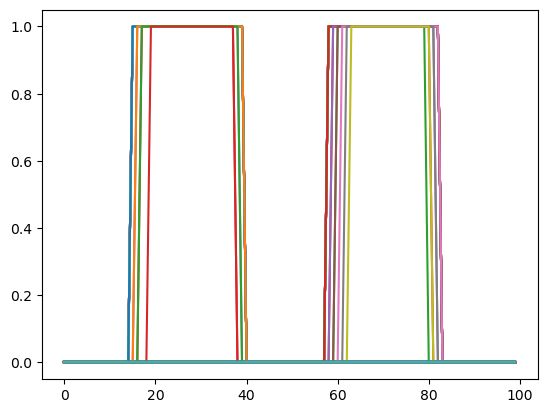

100-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f5e87751f90>
 PyObject <matplotlib.lines.Line2D object at 0x7f5e8777da90>
 PyObject <matplotlib.lines.Line2D object at 0x7f5e8777dc50>
 PyObject <matplotlib.lines.Line2D object at 0x7f5e8777de10>
 PyObject <matplotlib.lines.Line2D object at 0x7f5e8777dfd0>
 PyObject <matplotlib.lines.Line2D object at 0x7f5ebb1331d0>
 PyObject <matplotlib.lines.Line2D object at 0x7f5ebb133410>
 PyObject <matplotlib.lines.Line2D object at 0x7f5ebb1335d0>
 PyObject <matplotlib.lines.Line2D object at 0x7f5e8777df90>
 PyObject <matplotlib.lines.Line2D object at 0x7f5ebb133210>
 PyObject <matplotlib.lines.Line2D object at 0x7f5e87743d50>
 PyObject <matplotlib.lines.Line2D object at 0x7f5ebb133c10>
 PyObject <matplotlib.lines.Line2D object at 0x7f5ebb133dd0>
 ⋮
 PyObject <matplotlib.lines.Line2D object at 0x7f5ebb15a510>
 PyObject <matplotlib.lines.Line2D object at 0x7f5ebb15a6d0>
 PyObject <matplotlib.lines.Line2D object at

In [256]:
plot(img)

In [103]:
tspan = (0.0f0, 5f0)
u0 = cu(reshape(zeros(Float32, p.dim_i, p.dim_j*(5*p.K+2)), p.dim_i, p.dim_j, 5*p.K+2,1));

In [14]:
arr1 = u0[:, :, 1:p.K,:]
arr2 = u0[:, :, 1:1,:];

In [15]:
f = LaminartGPU.LamFunction(
    similar(arr1), #x
    similar(arr1), #m
    similar(arr1), #s
 similar(arr2), #x_lgn,
similar(arr1), #C,
similar(arr1), #H_z,
similar(arr1), # dy_temp,
similar(arr1), # dm_temp,
similar(arr1), # dz_temp,
similar(arr1), # ds_temp,
similar(arr2), # dv_temp,
similar(arr1), # H_z_temp,
similar(arr2), #  V_temp_1,
similar(arr2), #  V_temp_2,
similar(arr1), #  A_temp,
similar(arr1), #   B_temp
    );

In [16]:
prob = ODEProblem(f, u0, tspan, p);

In [9]:
@benchmark sol = solve(prob)

BenchmarkTools.Trial: 
  memory estimate:  28.76 MiB
  allocs estimate:  560894
  --------------
  minimum time:     315.634 ms (0.00% GC)
  median time:      321.098 ms (0.00% GC)
  mean time:        336.049 ms (2.70% GC)
  maximum time:     398.161 ms (11.25% GC)
  --------------
  samples:          16
  evals/sample:     1

In [22]:
@time sol = solve(prob)

  0.416763 seconds (562.10 k allocations: 28.857 MiB)


retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 20-element Array{Float32,1}:
 0.0
 1.0f-6
 9.345251f-6
 6.192009f-5
 0.00033172502
 0.0014759909
 0.005392259
 0.017146833
 0.051452193
 0.13315387
 0.28310412
 0.49007082
 0.7197511
 1.0883753
 1.4995799
 2.081981
 2.7438252
 3.448669
 4.4254713
 5.0
u: 20-element Array{CuArray{Float32,4,Nothing},1}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 